# Aplicações do Método de Monte Carlo

Na aula passada vimos coo funciona o método de Monte Carlo e sua aplicação à estatística (calculando o pi através da probabilidade de um ponto aleatório cair dentro do círculo) e propagação da barra de erro.

Hoje aplicaremos o método de Monte Carlo à integração numérica e método de mínimos quadrados.

## Método de Monte Carlo Aplicado à integração numérica

Das aulas 12 à 16 vimos que o método de integração numérica é utilizada para resolver problemas que são muito complicados ou impossíveis de serem resolvidos analiticamente. Nestes casos, propomos uma condição inicial para os valores de interesse e integramos ao longo de um intervalo para obter o valor final. Porém, em alguns casos, essas condições iniciais podem ter incertezas significativas. O que isso significaria para a barra de erro do resultado?

Vamos utilizar as mesmas funções disponibilizadas na aula 16 para a integração orbital e inserir uma variação nas condições iniciais.

In [1]:
from scipy.integrate import solve_ivp
import numpy as np
from tqdm import tqdm
import matplotlib.pyplot as plt

In [2]:
# Definimos a função 
def orbita(t, state_vector):
    """  Calcula as derivadas do movimento orbital de dois corpos
    
    Parameters
    ----------
    t: float
        Tempo
    state_vector : list
        Lista com 8 valores. Para cada corpo, as posições x,y e as velocidades vx,vy.
    """
    x1 = state_vector[0]
    y1 = state_vector[1]
    vx1 = state_vector[2]
    vy1 = state_vector[3]
    x2 = state_vector[4]
    y2 = state_vector[5]
    vx2 = state_vector[6]
    vy2 = state_vector[7]
    
    # Calcula a distância entre os dois corpos
    dx = (x2-x1)
    dy = (y2-y1)
    r = np.sqrt(dx**2+dy**2)
    r3 = r**3
    
    # Calcula a aceleração dos dois corpos.
    ax1 = (G*m2/r3)*dx
    ay1 = (G*m2/r3)*dy
    ax2 = -(G*m1/r3)*dx
    ay2 = -(G*m1/r3)*dy
    
    # Retorna as velocidade e acelerações como uma lista
    return [vx1, vy1, ax1, ay1, vx2, vy2, ax2, ay2]

In [3]:
# Definimos as constantes necessárias
G = 6.674184e-11 # m^3/(kg.s))
ua = 1.495978707e11 # m

In [4]:
# Definimos as massas de cada corpo
m1 = 1.989e30 # Massa do Sol em kg
m2 = 5.972e24 # Massa da Terra em kg

In [5]:
def corrige_cm(state_vector):
    """ Corrige o vetor de estado do Centro de Massa.
    
    Parameters
    ----------
    state_vector : list
        Lista com 8 valores. Para cada corpo, as posições x,y e as velocidades vx,vy.
    massas : list
        Lista com as massas.
    """
    # Obtem as componentes das posições e velocidades
    x1 = state_vector[0]
    y1 = state_vector[1]
    vx1 = state_vector[2]
    vy1 = state_vector[3]
    x2 = state_vector[4]
    y2 = state_vector[5]
    vx2 = state_vector[6]
    vy2 = state_vector[7]
    
    mt = m1+m2  # Massa Total
    
    # Posição do Centro de Massa
    xcm = (x1*m1+x2*m2)/mt
    ycm = (y1*m1+y2*m2)/mt
    
    # Velocidade do Centro de Massa
    vxcm = (vx1*m1+vx2*m2)/mt
    vycm = (vy1*m1+vy2*m2)/mt
    
    # Vetor de Estado Corrigido
    sv_corr = [x1 - xcm, y1 - ycm, vx1 - vxcm, vy1-vycm, x2-xcm, y2-ycm, vx2-vxcm, vy2-vycm]
    return sv_corr

Para o teste, vamos supor que as velocidades iniciais são: $v_x = 0 \pm 200$ m/s e $v_y = 30000 \pm 100$ m/s

In [6]:
# Geramos pontos aleatórios com distribuição normal
velx = np.random.normal(0, 120, size=100)
vely = np.random.normal(30000, 100, size=100)

# E realizamos uma integração numérica para cada par de velocidades.

t_span = [0, 4e7] 
resultado = []
for vx, vy in tqdm(zip(velx, vely)):
    z0 = [0, 0, 0, 0, 1*ua, 0, vx, vy]
    z0_corr = corrige_cm(z0)
    sol = solve_ivp(orbita, t_span, z0_corr, max_step=10000)
    resultado.append(sol)

100it [01:30,  1.10it/s]


In [7]:
# Agora pegamos todos os valores das posições e colocamos no formato de uma matriz para a Terra.
# Para o Sol, basta pegar as posições da primeira solução.

x_terra = []
y_terra = []
for s in resultado:
    x_terra.append(s.y[4])
    y_terra.append(s.y[5])
x_terra = np.array(x_terra).T
y_terra = np.array(y_terra).T
x_sol = resultado[0].y[0]
y_sol = resultado[0].y[1]
t = resultado[0].t

Para a simulação não precisamos mudar nada. Apenas removemos o desenho da linha da órbita.

In [8]:
# importamos do matplotlib o módulo de animação
# e importamos do Ipython a ferramenta para que a animação possa ser apresentada em HTML e visualizada no navegador
from matplotlib import animation
from IPython.display import HTML

# Quantos frames por segundo a animação deve apresentar
FPS=30  #
#plt.style.use('default')

# Cria o quadro onde a figura será desenhada no matplotlib e pega um ponteiro para o objeto deste quadro.
fig = plt.figure(figsize=(8, 8), dpi=100)

# Modifica os limites da figura para cobrir o quadro inteiro
ax = plt.axes(xlim=(-1.1, 1.1), ylim=(-1.1, 1.1))

# Garante que o eixo x e o eixo y possuam a mesma escala
ax.set_aspect('equal')

# remove os eixos que normalmente aparecem
ax.axis('off')

# Define os elementos da animação
terra, = ax.plot([], [], 'b.')  # Cria um ponto para a Terra e pega um ponteiro para o objeto deste ponto
sun, = ax.plot([], [], 'ro')  # Cria um ponto para o Sol e pega um ponteiro para o objeto deste ponto

# Define de quantos em quantos pontos da integração será o intervalo entre os frames.
step = 5  # O primeiro frame será a posição no tempo t[0], o segundo frame será a posição no tempo t[5] ...

# Pega o último valor do tempo para calcular o número de frames total
framesNum = int(len(t)/step)

def animate(j):
    """ Função de animação. Ela será chamada para cada frame
    
    Parameters
    ----------
    j : int
        Número do frame
    """
    # Calcula qual a posição da órbita será usada para o frame j
    # Isto é necessário porque não precisamos plotar todos os instantes de tempo.
    j = step*j
    
    # Em cada frame atualizamos a posição do círculo e da linha.
    # Isso é necessário porque consome mais processamento fazer plots diferentes para cada frame
    sun.set_data(x_sol[j]/ua, y_sol[j]/ua)
    terra.set_data(x_terra[j]/ua, y_terra[j]/ua)

# Cria a animação
anim = animation.FuncAnimation(fig, animate, frames=framesNum, interval=1000/FPS)

plt.close(anim._fig)

# Mostra a animação
# Pode demorar um pouco para aparecer.
HTML(anim.to_html5_video())

/tmp/ipykernel_20608/800049453.py:46: MatplotlibDeprecationWarning: Setting data with a non sequence type is deprecated since 3.7 and will be remove two minor releases later
  sun.set_data(x_sol[j]/ua, y_sol[j]/ua)


Com isso vemos as posições possíveis da Terra devido à incerteza das velocidades iniciais.

## Método de Monte Carlo aplicado a Mínimos Quadrados

Nas aulas 10 e 11 vimos o método de Mínimos Quadrados para determinação dos melhores parâmetros que ajustem uma função específica aos dados fornecidos.

Supondo um conjunto de pontos $(x_i, y_i \pm \sigma_{yi})$ e uma função $f(x)$, queremos obter os melhores parâmetros de $f(x)$ de forma a minimizar o erro total. Primeiramente, definimos o erro de cada ponto como:

\begin{equation}
e_i = f(x_i) - y_i \tag{1}
\end{equation}

Como cada ponto $y_i$ possui uma incerteza $\sigma_{yi}$ precisamos considerar essas incertezas de forma que aquele que possua maior incerteza contribua menos para o ajuste. Com isso, a função que queremos minimizar é o chamado chi-quadrado:

\begin{equation}
\chi^2 = \sum_i\frac{e_i^2}{\sigma_i^2} \tag{2}
\end{equation}

No problema passado no exercício de mínimos quadrados, ajustamos os pontos à função:

$$y = ax + bx^3$$

In [9]:
# lendo os dados
x, y, sigmay = np.loadtxt('dados2.txt', unpack=True)

In [10]:
# Utilizando o método de Monte Carlo, vamos chutar vários possíveis valores para "a" e para "b".
# Os valores escolhidos aqui já partem do princípio que sabemos razoavelmente onde é a solução.
# Às vezes, isso não é possível e precisamos chutar um intervalo muito grande pra depois ir convergindo à solução.
a = np.random.uniform(0, 0.02, 1000)
b = np.random.uniform(0, 0.002, 1000)

In [11]:
# Agora calculamos o chi-quadrado para todos os chutes de a e de b
chi_quadrado = np.zeros(len(a))
for i in range(len(a)):
    # Primeiramente determinamos os valores da função para cada par de coneficientes.
    fx = a[i]*x+b[i]*(x**3)
    # Agora utilizamos a equação (1) para determinar os erros de cada ponto
    e = fx - y
    # Por fim calculamos o chi-quadrado total
    chi2 = np.sum( (e**2) / (sigmay**2) )
    chi_quadrado[i] = chi2

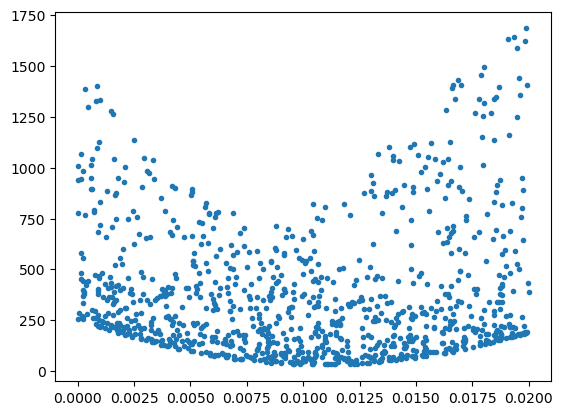

In [12]:
# Podemos visualizar os chi-quadrado em função dos coeficientes
plt.plot(a, chi_quadrado, '.')

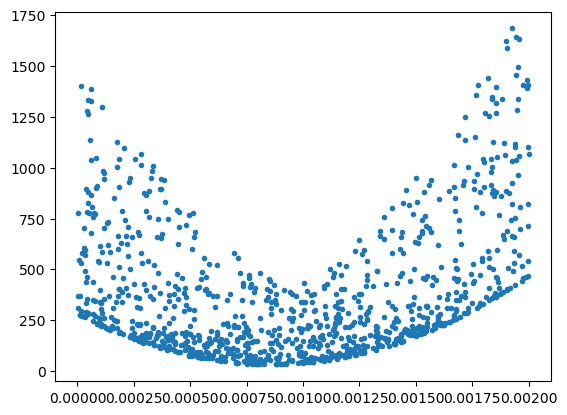

In [13]:
plt.plot(b, chi_quadrado, '.')

Vemos que existe um mínimo nos dois gráficos. Para obter o resultado final precisamos determinar os valores de "a" e de "b" onde o chi-quadrado é mínimos.

In [14]:
# Pega o item da lista de chi-quadrados onde está o chi-quadrado mínimo.
p = np.argmin(chi_quadrado)
# Utiliza o valor anterior para pegar os valores de "a" e de "b" onde o chi-quadrado é mínimo.
print(a[p])
print(b[p])

0.010434334129549987
0.0008864034600901527


**Existe muito mais sobre chi-quadrado do que isso, como por exemplo chi-quadrado sobre graus de liberdade e como obter a barra de incerteza de "a" e de "b", mas isso ficará para os cursos mais avançados.**